### 02_Regression_kc_house_data
[Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)  

Regression -> MSE(Mean Squared Error) or MAE(Mean Absolute Error)  
二元分類 -> BCE(Binary CroosEntropy)  
多元分類 -> CCE(Categorical CrossEntropy)  

from Ipython.display import Image  
from tensorflow.keras import utils  
utils.plot_model(model, to_file=filepath)  
Image(filepath)  

data["year"] = pd.to_numeric(data["date"].str.slice(0,4))  
data.drop(labels=["id","date"], axis="columns", inplace=True)  
np.random.permutation(x : int or array_like)  
model_cbk = callbacks.TensorBoard(log_dir=log_dir)  
model_mcbk = callbacks.ModelCheckpoint(model_dir+"model_02.h5",
                                       monitor="val_mean_absolute_error", save_best_only=True, mode="min")


In [1]:
import sys,os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,utils,layers,models
from tensorflow.keras import optimizers,losses,metrics
from tensorflow.keras import callbacks
from IPython.display import Image

import pandas as pd
import numpy as np

print(sys.version)
print(tf.__version__)

3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
2.0.0


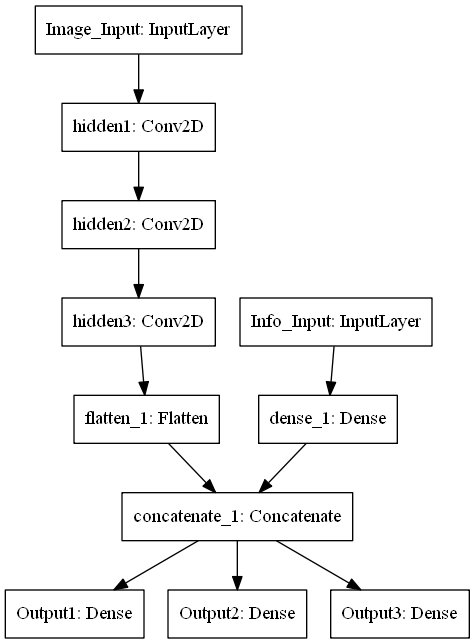

In [3]:
image_inputs = keras.Input(shape=(28, 28, 1), name='Image_Input')
hidden1 = layers.Conv2D(64, kernel_size=3, activation='relu', name='hidden1')(image_inputs)
hidden2 = layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', name='hidden2')(hidden1)
hidden3 = layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', name='hidden3')(hidden2)
flatten = layers.Flatten()(hidden3)

info_inputs = keras.Input(shape=(10, ), name='Info_Input')
hidden4 = layers.Dense(64)(info_inputs)

concat = layers.Concatenate()([flatten, hidden4])

weather_outputs = layers.Dense(1, name='Output1')(concat)
temp_outputs = layers.Dense(1, name='Output2')(concat)
humidity_outputs = layers.Dense(1, name='Output3')(concat)

model = keras.Model(inputs=[image_inputs, info_inputs], 
                    outputs=[weather_outputs, temp_outputs, humidity_outputs])

# 產生網絡拓撲圖
utils.plot_model(model, to_file='Functional_API_Multi_Input_Multi_Output_Model.png')

# 秀出網絡拓撲圖
Image('Functional_API_Multi_Input_Multi_Output_Model.png')

In [8]:
import pandas as pd
data = pd.read_csv("kc_house_data.csv")
print(data.shape)
pd.options.display.max_columns = 25
data.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：

date：房屋出售日期。  
price：房屋價格（目標）。  
bedrooms：臥室數量。  
bathrooms：浴室數量。  
sqft_living：居住的坪數（平方英尺）。  
sqft_lot：實際的坪數（平方英尺）。  
floors：房屋總共樓層。  
waterfront：海景房。  
view：房屋是否看過。  
condition：整體條件有多好。  
grade：房屋的整體等級（根據King County評分系統）。  
sqft_above：除了地下室外的坪數（平方英尺）。  
sqft_basement：地下室的坪數（平方英尺）。  
yr_built：房屋建造時間。  
yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。  
zipcode：郵政編碼。  
lat：緯度座標。  
long：經度座標。  
sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。  
sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。  

In [10]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 資料型態總共有五種：object(string),booleab, integer, float and categorical.
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [11]:
# 將date日期拆為年、月和日並轉成數值
data["year"] = pd.to_numeric(data["date"].str.slice(0,4))
data["month"] = pd.to_numeric(data["date"].str.slice(4,6))
data["day"] = pd.to_numeric(data["date"].str.slice(6,8))
data.drop(labels=["id","date"], axis="columns", inplace=True)
# do drop and return None
# inplace bool, default False
# If False, return a copy. Otherwise, do operation inplace and return None.
# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）

In [15]:
data_num = data.shape[0]
indexes = np.random.permutation(data_num)
print("data.shape",data.shape)
print("indexes.shape",indexes.shape)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]
print("propotion %d[6,2,2]"%data_num,"0",str(int(data_num *0.6)),str(int(data_num *0.8)),data_num)
print(train_data.shape,val_data.shape,test_data.shape)

data.shape (21613, 22)
indexes.shape (21613,)
propotion 21613[6,2,2] 0 12967 17290 21613
(12967, 22) (4323, 22) (4323, 22)


In [17]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()       
std = train_validation_data.std()  

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [20]:
print("train_data.shape",train_data.shape)
x_train = np.array(train_data.drop("price", axis="columns"))
y_train = np.array(train_data["price"])
print("train_data.drop(~,inplace=False)")
print("# inplace, default False. If False, return a copy. Otherwise, do operation inplace and return None.")
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])
print("train_data.shape",train_data.shape)
print("x_train.shape",x_train.shape)
print("y_train.shape",y_train.shape)
print("x_val.shape",x_val.shape)
print("y_val.shape",y_val.shape)

train_data.shape (12967, 22)
train_data.drop(~,inplace=False)
# inplace, default False. If False, return a copy. Otherwise, do operation inplace and return None.
train_data.shape (12967, 22)
x_train.shape (12967, 21)
y_train.shape (12967,)
x_val.shape (4323, 21)
y_val.shape (4323,)


In [2]:
def dataset_normalize(filepath, scale=1):
    data = pd.read_csv(filepath)
    data["year"] = pd.to_numeric(data["date"].str.slice(0,4))
    data["month"] = pd.to_numeric(data["date"].str.slice(4,6))
    data["day"] = pd.to_numeric(data["date"].str.slice(6,8))
    data.drop(labels=["id","date"], axis="columns", inplace=True)
    # do drop and return None
    
    data_num = data.shape[0] // scale
    indexes = np.random.permutation(data_num)
    # [propotion 6,2,2]
    train_num = int(data_num*0.6)
    test_num = int(data_num*0.2)
    train_indexes = indexes[:train_num]
    val_indexes = indexes[train_num:test_num]
    test_indexes = indexes[test_num:]
    train_data = data.loc[train_indexes]
    val_data = data.loc[val_indexes]
    test_data = data.loc[test_indexes]
    
    normalization_data = pd.concat([train_data,val_data])
    mean = normalization_data.mean()
    std = normalization_data.std()
    train_data = (train_data-mean) / std
    val_data = (val_data-mean) / std
    
    x_train = np.array(train_data.drop(labels=["price"], axis="columns"))
    y_train = np.array(train_data["price"])
    x_val = np.array(val_data.drop(labels=["price"], axis="columns"))
    y_val = np.array(val_data["price"])
    
    x_test = np.array(test_data.drop(labels=["price"], axis="columns"))
    
    return (x_train,y_train), (x_val,y_val), x_test

filepath = "kc_house_data.csv"
train_data, val_data, test_data = dataset_normalize(filepath, scale=10)

In [3]:
def build_model():
    model = models.Sequential(name="model_02")
    model.add(layers.Dense(64, activation="relu", input_shape=(21,)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation="softmax"))  
                               
    return model

model = build_model()
model.summary()

Model: "model_02"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer = optimizers.Adam(0.005)
loss=losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.MeanAbsoluteError()])

In [5]:
# model_dir = "models/lab2_logs/"
# log_dir = "models/lab2_logs/model_02/"
# os.makedirs(model_dir, exist_ok=True)
# os.makedirs(log_dir, exist_ok=True)
# model_cbk = callbacks.TensorBoard(log_dir=log_dir)
# # ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
# model_mcbk = callbacks.ModelCheckpoint(model_dir+"model_02.h5",
#                                       monitor="val_mean_absolute_error",
#                                       save_best_only=True,
#                                       mode="min")

In [6]:
# #model_dir = 'lab2-logs/models/'
# model_dir = os.path.join("lab2-logs","models","Best-model-1.h5")
# os.makedirs(model_dir, exist_ok=True)
# model_path = model_dir + '/Best-model-1.h5'
# # TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
# log_dir = os.path.join('lab2-logs', 'model-1')
# os.makedirs(log_dir, exist_ok=True)
# model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# # ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
# model_mckp = keras.callbacks.ModelCheckpoint(model_dir, 
#                                         monitor='val_mean_absolute_error', 
#                                         save_best_only=True, 
#                                         mode='min')

In [ ]:
(x_train,y_train) = train_data
(x_val,y_val) = val_data
batch_size=3
epochs=3

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(x_val,y_val))

Train on 1296 samples
Epoch 1/3
1242/1296 [===========================>..] - ETA: 0s - loss: 2.0230 - accuracy: 0.0000e+00

In [ ]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))